In [1]:
#@title ⬇️ Download Validation Data and Annotation & Setup SAM 3

# --- SAM 3 INSTALLATION (Added) ---
# We need the development version of transformers because SAM 3 is brand new (Nov 2025).
print("⚙️ Installing SAM 3 dependencies (transformers, accelerate, huggingface_hub)...")
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git accelerate huggingface_hub
print("✅ SAM 3 Libraries installed.\n")
# ----------------------------------

import os, requests, zipfile

def download_and_unzip(url, extract_to, chain_path):
    """Download and unzip using a verified SSL certificate."""
    if os.path.exists(extract_to):
        print(f"The directory '{extract_to}' already exists. Skipping download and extraction.")
        return

    local_zip = os.path.basename(url)
    print(f"📥 Downloading {local_zip} (approx 1min)...")

    try:
        response = requests.get(url, stream=True, verify=chain_path, timeout=20)
        response.raise_for_status()
        with open(local_zip, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ {local_zip} downloaded successfully ({os.path.getsize(local_zip)} bytes)")

        print(f"📂 Extracting to '{extract_to}/'...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(local_zip, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(local_zip)
        print(f"✅ Extraction completed to '{extract_to}'")

    except requests.exceptions.RequestException as e:
        print(f"❌ Download error: {e}")
    except zipfile.BadZipFile:
        print("❌ The downloaded file is not a valid ZIP archive.")
    except Exception as e:
        print(f"⚠️ Unexpected error: {e}")

chain_path = "/content/chain-harica-cross.pem"
print("🔐 Downloading SSL certificate chain...")
cert_url = "https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem"
r = requests.get(cert_url, timeout=10, stream=True)
r.raise_for_status()
with open(chain_path, "wb") as f:
    f.write(r.content)
print("✅ Certificate chain downloaded.\n")
zip_url = "https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip"
extract_directory = "/content/val_data"
download_and_unzip(zip_url, extract_directory, chain_path)

print("\n🎯 All done!")

⚙️ Installing SAM 3 dependencies (transformers, accelerate, huggingface_hub)...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
✅ SAM 3 Libraries installed.

🔐 Downloading SSL certificate chain...
✅ Certificate chain downloaded.

The directory '/content/val_data' already exists. Skipping download and extraction.

🎯 All done!


Always click <img src="https://su2.utia.cas.cz/files/labs/final2025/play.png" height="20px"> to run each script below.

In [2]:
#@title 🛠️ Setup (imports + funcs)

import matplotlib.animation as animation
from IPython.display import HTML, display, clear_output
import subprocess
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 150
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.collections as mc
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from torch.utils.data import IterableDataset
from typing import Tuple, Union
from scipy.ndimage import gaussian_filter, maximum_filter
import ipywidgets as widgets
import math
from scipy import spatial, optimize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import time
import threading
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in cuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)



def open_tiff_file(name: str) -> np.ndarray:
    img = Image.open(name)

    frames = []
    for i in range(img.n_frames):
        img.seek(i)
        frames.append(np.array(img))

    return np.array(frames).squeeze()

def loading_html(message: str) -> str:
    return f"""
<div id="loading-msg">
  <br /><br />
  <b><span style='display:inline-block;animation:flipPause 2s ease infinite;'>⏳</span>
  {message}</b>
</div>
<style>
@keyframes flipPause {{
  0% {{transform:rotate(0deg);}}
  40%{{transform:rotate(180deg);}}
  50%{{transform:rotate(180deg);}}
  90%{{transform:rotate(360deg);}}
  100%{{transform:rotate(360deg);}}
}}
</style>
"""

html_code_reconstruction = loading_html("Showing input validation data, please wait...")

def replace_loading_js(message: str, delay_ms: int = 0) -> str:
    return f"""
<script>
  setTimeout(function(){{
    var loadingDiv = document.getElementById("loading-msg");
    if (loadingDiv) {{
      loadingDiv.innerHTML = '<br /><b>{message}</b>';
    }}
  }}, {delay_ms});
</script>
"""

replace_loading_js_default = replace_loading_js("Only the first 50 frames are displayed.")
replace_loading_js_empty = replace_loading_js("")


class OTF:
    """
    The Optical Transfer Function of the optical system.
    Generates a 2-D image from an exponential approximation of the ideal OTF.
    """

    def __init__(self, na: float, wavelength: float, pixel_size: float, image_size: int, curvature: float):
        """
        :param na: Numerical aperture of the optical system.
        :param wavelength: Wavelength of the emitted light in nanometers.
        :param pixel_size: Physical size of the image pixel in micrometers.
        :param image_size: Width and height of the image.
        :param curvature: Bend of the model OTF function in [0, 1] range where 1 is a perfect OTF.
        :param samples: Number of values to sample.
        """
        cutoff_frequency = 1000 * 2 * na / wavelength  # in micrometer^-1 (for incoherent imaging)
        self.image_cutoff = cutoff_frequency * pixel_size * image_size
        self.image_size = image_size
        self.curvature = curvature

    def __call__(self, size: int = None, x_shift: float = 0, y_shift: float = 0) -> np.ndarray:
        """
        Generate a 2-D image representation.
        :param size: Width and height of the generated image.
        :param x_shift: Sub-pixel shift along the x-axis of the OTF center.
        :param y_shift:Sub-pixel shift along the y-axis of the OTF center.
        :return: 2-D representation of the OTF
        """
        if size is None:
            size = self.image_size

        x, y = np.meshgrid(np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]),
                           np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]))
        distance_to_origin = np.hypot(x + x_shift, y + y_shift)

        return self.value(np.minimum(distance_to_origin / self.image_cutoff, 1))

    def double(self, x_shift: float = 0, y_shift: float = 0) -> np.ndarray:
        return self(self.image_size * 2, x_shift, y_shift)

    def value(self, x):
        return (2 / np.pi) * (np.arccos(x) - x * np.sqrt(1 - x * x)) * self.curvature ** x

def apodization_filter(dist_ratio: float, bend: float, size: int) -> np.ndarray:
    """
    Generate an apodization filter that can be directly multiplied with the summed fft result image.

    :param dist_ratio: A coefficient that transform the point distance in pixels to a value where [0, 1] range
        corresponds to the extended OTF support.
    :param bend: A coefficient in the [0, 1] range defining how much medium frequencies should be augmented.
    :param size: Size of the apodization filter.
    :return: np.ndarray of size (size, size) of the apodization filter.
    """
    x, y = np.meshgrid(np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]),
                       np.hstack([np.arange(size // 2), np.arange(-size // 2, 0)]))

    distance = np.hypot(x, y) * dist_ratio
    mask = np.bitwise_and(0 <= distance, distance < 1)

    apo = np.power(
        (2 / np.pi) * (np.arccos(distance, where=mask) - distance * np.sqrt(1 - distance * distance, where=mask)),
        bend,
        where=mask
    )

    return np.where(mask, apo, 0)


def wiener_filter(shifts, otf: OTF, w: float, size: int) -> np.ndarray:
    """
    Generate a wiener filter denominator so that it can be directly multiplied with the summed fft result image.

    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param otf: OTF object.
    :param w: Wiener parameter.
    :param size: Size of the wiener filter.
    :return: np.ndarray of size (size, size) of the Wiener filter denominator.
    """
    otf0 = np.abs(otf(size)) ** 2
    wiener = 3 * otf0

    for i in range(3):
        otf1 = np.abs(otf(size, shifts[i][1], shifts[i][0])) ** 2
        otf2 = np.abs(otf(size, -shifts[i][1], -shifts[i][0])) ** 2

        wiener += otf1 + otf2

    return 1 / (wiener + w * w)

def map_otf_support(components: np.ndarray, shifts, otf: OTF) -> None:
    """
    Multiply conjugated OTF to corresponding parts of it's support in the separated and shifted components. Values
    outside the OTF support are set to zero. This function alters the original images.

    :param components: np.ndarray of shape (9, size, size) of padded separated and shifted components in frequency space.
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param otf: OTF object
    """
    size = components.shape[-1]

    components[::3] *= np.conjugate(otf(size))
    for i in range(3):
        components[i * 3 + 1] *= np.conjugate(otf(size, shifts[i][1], shifts[i][0]))
        components[i * 3 + 2] *= np.conjugate(otf(size, -shifts[i][1], -shifts[i][0]))


def fourier_shift(fft_image: np.ndarray, x_shift: Union[float, np.ndarray], y_shift: Union[float, np.ndarray]) -> np.ndarray:
    """
    Use the fourier shift theorem to perform a sub-pixel shift of a frequency image in the spatial domain.

    It is implemented in a way that allows the x_shift and y_shift parameters to be a np.ndarray of arbitrary shape with
    the last two axes being np.newaxis or None. The returned array shape is then x/y_shift.shape + (height, width)

    :param fft_image: np.ndarray of shape (height, width).
    :param x_shift: Sub-pixel shift along the x-axis.
    :param y_shift: Sub-pixel shift along the y-axis.
    :return: np.ndarray of shape (height, width) of the shifted frequency image.
    """
    height, width = fft_image.shape[-2:]

    spatial_image = np.fft.ifft2(fft_image)

    x_indices = np.arange(-width // 2, width // 2, dtype=int)
    y_indices = np.arange(-height // 2, height // 2, dtype=int)

    x = np.exp(-1j * 2 * np.pi * x_shift * x_indices[None, :] / width)
    y = np.exp(-1j * 2 * np.pi * y_shift * y_indices[:, None] / height)

    shifted_spatial_image = spatial_image * (x * y)

    return np.fft.fft2(shifted_spatial_image)


def shift_components(components: np.ndarray, shifts) -> None:
    """
    Use the fourier shift theorem to perform a sub-pixel shift of frequency components in the spatial domain. This
    function alters the original images.

    :param components: np.ndarray of shape (9, height, width) of padded separated components in frequency space.
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :return: np.ndarray of shape (9, height, width) of shifted components.
    """
    for i in range(3):
        components[i * 3 + 1, ...] = fourier_shift(components[i * 3 + 1, ...], shifts[i][1], shifts[i][0])
        components[i * 3 + 2, ...] = fourier_shift(components[i * 3 + 2, ...], -shifts[i][1], -shifts[i][0])


def pad_components(components: np.ndarray) -> np.ndarray:
    """
    Pad an image to twice its size from the center, keeping the corners intact.
    This makes it possible to pad images that are NOT centered using np.fft.fftshift.

    :param components: np.ndarray of shape (..., size, size) of separated components in frequency space.
    :return: np.ndarray of shape (..., size, size) padded with zeros from the center.
    """
    size = components.shape[-1]
    padded_components = np.zeros(components.shape[:-2] + (size * 2, size * 2), dtype=np.complex128)

    x, y = np.meshgrid(
        np.hstack([np.arange(size // 2), np.arange(size * 3 // 2, size * 2)]),
        np.hstack([np.arange(size // 2), np.arange(size * 3 // 2, size * 2)])
    )

    padded_components[..., y, x] = components

    return padded_components

def _component_separation_matrix(phase_offset: float = 0, modulation: float = 1) -> np.ndarray:
    phases = np.array([0, 2 * np.pi / 3, 4 * np.pi / 3]) + phase_offset

    M = np.ones((3, 3), dtype=np.complex128)


    M[:, 1] = 0.5 * modulation * (np.cos(phases) + 1j * np.sin(phases))
    M[:, 2] = 0.5 * modulation * (np.cos(-phases) + 1j * np.sin(-phases))

    return np.linalg.inv(M)

def separate_components(fft_images: np.ndarray, phase_offsets=np.zeros(3), phase_modulations=np.ones(3)) -> np.ndarray:
    """
    Compute the spectral separation of components.

    :param fft_images: np.ndarray of shape (9, height, width) of images in frequency space.
    :param phase_offsets: A container of length 3 of phase offsets for each of the 3 orientations, zeros by default.
    :param phase_modulations: A container of length 3 of phase modulations for each of the 3 orientations,
        ones by default.
    :return: np.ndarray of shape (9, height, width) of separated components.
    """
    separation_matrices = np.array([_component_separation_matrix(phase_offsets[i], phase_modulations[i])
                                    for i in range(3)])

    return np.einsum('aij,ajkl->aikl',separation_matrices,
                     fft_images.reshape(3, 3, *fft_images.shape[1:])).reshape(9, *fft_images.shape[1:])


def run_reconstruction(fft_images: np.ndarray, otf: OTF, shifts, phase_offsets, modulations, config: dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a SIM reconstruction using the provided parameters.

    :param fft_images: np.ndarray of shape (9, height, width) of images in frequency space.
    :param otf: OTF object
    :param shifts: A container of length 3 of shifts of the second component for each of the 3 orientations.
    :param phase_offsets: A container of length 3 of phase offsets for each of the 3 orientations.
    :param modulations: A container of length 3 of phase modulations for each of the 3 orientations.
    :param config: A dictionary of SIM reconstruction parameters. It must contain the following keys: ["wavelength",
        "na", "px_size", "apo_cutoff", "wiener_parameter", "apo_bend"]
    :return: fft_result, spatial_result
    """
    size = fft_images.shape[-1]
    cutoff = 1000 * 2 * config["na"] / config["wavelength"]
    apo_dist_ratio = 1 / (config["px_size"] * config["apo_cutoff"] * cutoff * size)

    components = separate_components(fft_images, phase_offsets, modulations)
    components = pad_components(components)

    shift_components(components, shifts)
    map_otf_support(components, shifts, otf)

    wiener = wiener_filter(shifts, otf, config["wiener_parameter"], size * 2)
    apodization = apodization_filter(apo_dist_ratio, config["apo_bend"], size * 2)

    fft_result = np.sum(components, 0) * wiener * apodization
    spatial_result = np.real(np.fft.ifft2(fft_result))

    return fft_result, spatial_result

def illumination_pattern(angle, frequency, phase_offset, amplitude, size) -> np.ndarray:
    n = size // 2
    Y, X = np.mgrid[-n:n, -n:n]
    ky, kx = np.sin(angle) * frequency, np.cos(angle) * frequency
    return 1 + amplitude * np.cos(2 * np.pi * (X * kx + Y * ky) + phase_offset)


class PerlinNoise:
    """Adapted from: https://github.com/pvigier/perlin-numpy"""

    def __init__(self, size: int, res: int):
        """
        :param size: length of both dimensions of the generated noise image
        :param res: number of periods of noise to generate along each axis
        """

        meshgrid = np.mgrid[0:res:res / size, 0:res:res / size]
        self.grid = np.stack(meshgrid) % 1

        self.t = self._fade(self.grid)
        self.d = size // res
        self.sample_size = (res + 1, res + 1)

    def __call__(self) -> np.array:
        """
        Returned values are always in the [0, 1] range with ~0.5 mean
        """
        angles = 2 * np.pi * np.random.random_sample(self.sample_size)
        gradients = np.dstack((np.cos(angles), np.sin(angles))).repeat(self.d, 0).repeat(self.d, 1)

        n00 = (np.dstack((self.grid[0], self.grid[1])) * gradients[:-self.d, :-self.d]).sum(2)
        n10 = (np.dstack((self.grid[0] - 1, self.grid[1])) * gradients[self.d:, :-self.d]).sum(2)
        n01 = (np.dstack((self.grid[0], self.grid[1] - 1)) * gradients[:-self.d, self.d:]).sum(2)
        n11 = (np.dstack((self.grid[0] - 1, self.grid[1] - 1)) * gradients[self.d:, self.d:]).sum(2)

        n0 = n00 * (1 - self.t[0]) + n10 * self.t[0]
        n1 = n01 * (1 - self.t[0]) + n11 * self.t[0]

        return 0.5 + 2 ** -0.5 * (n0 * (1 - self.t[1]) + n1 * self.t[1])

    @staticmethod
    def _fade(t):
        return 6 * t ** 5 - 15 * t ** 4 + 10 * t ** 3


class SyntheticDataset(IterableDataset):
    def __init__(self, contrast_fg_range: tuple[float,float] = (0.0, 1.0), contrast_bg_range: tuple[float,float] = (0.0, 1.0)):
        self.patch_size = 128

        self.contrast_fg_range = contrast_fg_range
        self.contrast_bg_range = contrast_bg_range

        self.frequency = 0.17
        self.amplitude = 1.0

        self.config = {
            "na": 1.49,
            "wavelength": 512,
            "px_size": 0.07,
            "wiener_parameter": 0.1,
            "apo_cutoff": 2.0,
            "apo_bend": 0.9
        }

        self.otf = OTF(self.config['na'], self.config['wavelength'], self.config['px_size'], self.patch_size // 2, 0.3)
        self.otf_mult = self.otf(self.patch_size)

        self.perlin = PerlinNoise(self.patch_size, 1)

    def _simulate_sim(self, image):
        angle0 = np.random.uniform(0, np.pi * 2)
        phase_offsets = np.random.uniform(0, np.pi * 2, 3)

        shifts = [(self.frequency * self.patch_size * np.sin(angle0 + i * np.pi / 3),
                   self.frequency * self.patch_size * np.cos(angle0 + i * np.pi / 3))
                  for i in range(3)]

        illumination = np.stack([illumination_pattern(angle0 + i // 3 * np.pi / 3,
                                                      self.frequency,
                                                      phase_offsets[i // 3] + (i % 3) * np.pi * 2 / 3,
                                                      self.amplitude,
                                                      self.patch_size)
                                 for i in range(9)])


        fg_c = np.random.uniform(*self.contrast_fg_range)
        bg_c = np.random.uniform(*self.contrast_bg_range)
        foreground = 250 + fg_c * 500
        background = 50 + bg_c * 50

        high_res_image = (image * foreground + background) * self.perlin()

        ix = np.fft.fft2(illumination * high_res_image)
        hix = self.otf_mult * ix
        dhix = hix.reshape(9, 2, self.patch_size // 2, 2, self.patch_size // 2).sum((1, 3)) / 4
        low_res_images = np.random.poisson(np.fft.ifft2(dhix).real).astype(np.float64)

        noisy_shifts = [np.random.triangular((y - 0.25, x - 0.25), (y, x), (y + 0.25, x + 0.25)) for y, x in shifts]
        noisy_phase_offsets = np.random.normal(phase_offsets, np.pi / 6)
        noisy_amplitudes = np.random.normal(self.amplitude, 0.1, 3)

        reconstruction = run_reconstruction(np.fft.fft2(low_res_images), self.otf, noisy_shifts, noisy_phase_offsets, noisy_amplitudes, self.config)[1]
        return (reconstruction - np.mean(reconstruction)) / np.std(reconstruction)

class SyntheticCCPDataset(SyntheticDataset):
    def __init__(self,min_n: int = 5, max_n: int = 15, radius: float = 2.5,
        contrast_fg_range: tuple[float,float] = (0.0, 1.0),
        contrast_bg_range: tuple[float,float] = (0.0, 1.0)):
        super().__init__(
            contrast_fg_range=contrast_fg_range,
            contrast_bg_range=contrast_bg_range
        )

        self.patch_size = 128

        # Possible positions
        yy, xx = np.mgrid[15:self.patch_size - 1:16, 15:self.patch_size - 1:16]
        self.yy = yy.flatten()
        self.xx = xx.flatten()

        # validate
        if not (0 <= min_n < max_n <= 49):
            raise ValueError("Require 0 <= min_n < max_n <= 49")
        self.min_n, self.max_n = min_n, max_n

        self.max_offset = 8
        assert self.max_offset < 16

        # Beta params
        self.beta_a = 2
        self.beta_b = 1

        # CCP shape params
        self.radius = radius
        self.thickness = 1.0

        # Patch positions
        self.yyy, self.xxx = np.mgrid[:self.patch_size, :self.patch_size]

    def __iter__(self):
        while True:
            yield self.data_sample()

    def data_sample(self):
        # Generate positions and classes
        n = np.random.randint(self.min_n, self.max_n)
        indices = np.random.choice(len(self.yy), size=n, replace=False)
        offsets = np.random.uniform(-self.max_offset, self.max_offset, (n, 2))
        positions = np.column_stack([self.yy[indices], self.xx[indices]]) + offsets
        classes = np.random.beta(self.beta_a, self.beta_b, n) * 0.9 + 0.1

        # Generate simulated HR image and output target
        target_distance = classes * self.radius
        distance = np.hypot(self.yyy[..., None] - positions[:, 0], self.xxx[..., None] - positions[:, 1])
        abs_distance = np.abs(distance - target_distance)
        parts = np.where(abs_distance > self.thickness, 0, np.log(np.interp(abs_distance / self.thickness, [0, 1], [np.e, 1])))
        full_image = np.sum(parts, -1)

        distances = np.maximum(classes - distance / ((1 - classes) * 2 + self.radius + self.thickness * 2), 0)
        y = np.minimum(np.sum(distances, -1), 1)

        # Generate simulated SIM image
        x = super()._simulate_sim(full_image)

        return x, y

def hota(gt: pd.DataFrame, tr: pd.DataFrame, threshold: float = 5) -> dict[str, float]:
    """Slightly adapted from https://github.com/JonathonLuiten/TrackEval"""

    # Ensure particle ids are sorted from 0 to max(n)
    gt = gt.copy()
    tr = tr.copy()

    gt.track_id = gt.track_id.map({old: new for old, new in zip(gt.track_id.unique(), range(gt.track_id.nunique()))})
    tr.track_id = tr.track_id.map({old: new for old, new in zip(tr.track_id.unique(), range(tr.track_id.nunique()))})

    # Initialization
    num_gt_ids = gt.track_id.nunique()
    num_tr_ids = tr.track_id.nunique()

    frames = sorted(set(gt.frame.unique()) | set(tr.frame.unique()))

    potential_matches_count = np.zeros((num_gt_ids, num_tr_ids))
    gt_id_count = np.zeros((num_gt_ids, 1))
    tracker_id_count = np.zeros((1, num_tr_ids))

    HOTA_TP, HOTA_FN, HOTA_FP = 0, 0, 0
    LocA = 0.0

    # Compute similarities (inverted normalized distance)
    similarities = [1 - np.clip(spatial.distance.cdist(gt[gt.frame == t][['x', 'y']],
                                                       tr[tr.frame == t][['x', 'y']]) / threshold, 0, 1)
                    for t in frames]

    # Accumulate global track information
    for t in frames:
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        similarity = similarities[t]
        sim_iou_denom = similarity.sum(0)[np.newaxis, :] + similarity.sum(1)[:, np.newaxis] - similarity
        sim_iou = np.zeros_like(similarity)
        sim_iou_mask = sim_iou_denom > 0 + np.finfo('float').eps
        sim_iou[sim_iou_mask] = similarity[sim_iou_mask] / sim_iou_denom[sim_iou_mask]
        potential_matches_count[gt_ids_t[:, None], tr_ids_t[None, :]] += sim_iou

        gt_id_count[gt_ids_t] += 1
        tracker_id_count[0, tr_ids_t] += 1

    global_alignment_score = potential_matches_count / (gt_id_count + tracker_id_count - potential_matches_count)
    matches_count = np.zeros_like(potential_matches_count)

    # Calculate scores for each timestep
    for t in frames:
        gt_ids_t = gt[gt.frame == t].track_id.to_numpy()
        tr_ids_t = tr[tr.frame == t].track_id.to_numpy()

        if len(gt_ids_t) == 0:
            HOTA_FP += len(tr_ids_t)
            continue

        if len(tr_ids_t) == 0:
            HOTA_FN += len(gt_ids_t)
            continue

        similarity = similarities[t]
        score_mat = global_alignment_score[gt_ids_t[:, None], tr_ids_t[None, :]] * similarity

        match_rows, match_cols = optimize.linear_sum_assignment(-score_mat)

        actually_matched_mask = similarity[match_rows, match_cols] > 0
        alpha_match_rows = match_rows[actually_matched_mask]
        alpha_match_cols = match_cols[actually_matched_mask]

        num_matches = len(alpha_match_rows)

        HOTA_TP += num_matches
        HOTA_FN += len(gt_ids_t) - num_matches
        HOTA_FP += len(tr_ids_t) - num_matches

        if num_matches > 0:
            LocA += sum(similarity[alpha_match_rows, alpha_match_cols])
            matches_count[gt_ids_t[alpha_match_rows], tr_ids_t[alpha_match_cols]] += 1

    ass_a = matches_count / np.maximum(1, gt_id_count + tracker_id_count - matches_count)
    AssA = np.sum(matches_count * ass_a) / np.maximum(1, HOTA_TP)
    DetA = HOTA_TP / np.maximum(1, HOTA_TP + HOTA_FN + HOTA_FP)
    HOTA = np.sqrt(DetA * AssA)

    return {'HOTA': HOTA, 'AssA': AssA, 'DetA': DetA, 'LocA': LocA,
            'HOTA TP': HOTA_TP, 'HOTA FN': HOTA_FN, 'HOTA FP': HOTA_FP}


def link_detections(detections_per_frame: list[list[tuple[int, int]]],
                    max_dist: float = 7.0) -> pd.DataFrame:
    """Link detections across frames into tracks using nearest neighbour association.

    Args:
        detections_per_frame: a list where each element is a list of (x,y)
            detections for the corresponding frame index.
        max_dist: maximum allowed distance in pixels between a detection and
            an existing track’s last position for association.  If no
            detection falls within this radius the track is terminated and
            a new track is started for the unmatched detection.

    Returns:
        A pandas DataFrame with columns ['frame','x','y','track_id'] containing
        the linked tracks.
    """
    next_track_id = 0
    active_tracks: dict[int, tuple[int, int, int]] = {}  # track_id -> (x, y, last_frame)
    records: list[dict[str, int]] = []
    for frame_idx, detections in enumerate(detections_per_frame):
        assigned = [False] * len(detections)
        detection_track_id: list[int | None] = [None] * len(detections)
        updated_tracks: dict[int, tuple[int, int, int]] = {}
        # attempt to match existing tracks to current detections
        for track_id, (tx, ty, last_frame) in list(active_tracks.items()):
            best_dist = max_dist
            best_idx: int | None = None
            for i, (x, y) in enumerate(detections):
                if assigned[i]:
                    continue
                dist = math.hypot(x - tx, y - ty)
                if dist < best_dist:
                    best_dist = dist
                    best_idx = i
            if best_idx is not None:
                # assign detection to this track
                assigned[best_idx] = True
                detection_track_id[best_idx] = track_id
                updated_tracks[track_id] = (detections[best_idx][0], detections[best_idx][1], frame_idx)
            # tracks with no assignment are dropped (no occlusion handling)
        # start new tracks for unmatched detections
        for i, (x, y) in enumerate(detections):
            if not assigned[i]:
                track_id = next_track_id
                next_track_id += 1
                detection_track_id[i] = track_id
                updated_tracks[track_id] = (x, y, frame_idx)
        # update active tracks
        active_tracks = updated_tracks
        # record detections with assigned track ids
        for i, (x, y) in enumerate(detections):
            tid = detection_track_id[i]
            records.append({'frame': frame_idx, 'x': x, 'y': y, 'track_id': tid})
    return pd.DataFrame(records)


def show_tracking(data, image_stack,
                  y_min=512, y_max=768, x_min=256, x_max=512,
                  tail_length=10, color='yellow', show_roi=True):
    """
    Visualize CCP trajectories within a defined ROI, from either a CSV file or a DataFrame.

    Args:
        data (str | pd.DataFrame): Path to CSV file or a DataFrame containing trajectories.
        image_stack (np.ndarray): 3D numpy array (frames, height, width).
        y_min, y_max, x_min, x_max (int): ROI bounds.
        tail_length (int): Number of frames for trajectory tails.
        color (str): Trajectory color.
        show_roi (bool): Whether to display cyan ROI rectangle on the full frame.
    """

    if isinstance(data, str):
        trajectories_df = pd.read_csv(data)
    elif isinstance(data, pd.DataFrame):
        trajectories_df = data.copy()
    else:
        raise TypeError("`data` must be a CSV file path or a pandas DataFrame.")

    tracks_in_roi = trajectories_df.groupby('track_id').filter(
        lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
    )

    html_code_linking = loading_html("Loading cropped region and tracks, please wait...")
    display(HTML(html_code_linking))

    if show_roi:
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(image_stack[0], cmap='magma')
        rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                         linewidth=2, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)
        ax.set_title("Full image (cyan box shows cropped region)")
        plt.show()

    def animate_trajectories_cropped(trajectories_df, image_stack, tail_length=10, color='yellow'):
        cropped_stack = image_stack[:, y_min:y_max, x_min:x_max]

        fig, ax = plt.subplots()
        im = ax.imshow(cropped_stack[0], cmap='magma')
        particles = trajectories_df['track_id'].unique()

        line_collections = {pid: mc.LineCollection([], linewidths=1, colors=color) for pid in particles}
        for lc in line_collections.values():
            ax.add_collection(lc)

        dot = ax.scatter([], [], s=5, c=color)

        def animate(i):
            im.set_array(cropped_stack[i])

            window = trajectories_df[
                (trajectories_df['frame'] >= i - tail_length) &
                (trajectories_df['frame'] <= i)
            ]

            now = window[window['frame'] == i]
            if len(now) > 0:
                coords = np.column_stack((now.x.values - x_min, now.y.values - y_min))
                dot.set_offsets(coords)
            else:
                dot.set_offsets(np.empty((0, 2)))

            for pid in particles:
                traj = window[window['track_id'] == pid].sort_values('frame')
                if len(traj) >= 2:
                    segs = [
                        [(x0 - x_min, y0 - y_min), (x1 - x_min, y1 - y_min)]
                        for (x0, y0, x1, y1) in zip(
                            traj.x.values[:-1], traj.y.values[:-1],
                            traj.x.values[1:], traj.y.values[1:]
                        )
                    ]
                    line_collections[pid].set_segments(segs)
                else:
                    line_collections[pid].set_segments([])

            return [im, dot] + list(line_collections.values())

        ani = FuncAnimation(fig, animate, frames=cropped_stack.shape[0], interval=100, blit=True)
        plt.close(fig)
        return HTML(ani.to_jshtml())

    html = animate_trajectories_cropped(tracks_in_roi, image_stack, tail_length, color)
    display(html)
    display(HTML(replace_loading_js_empty))

    print("Total number of trajectories in ROI:", len(tracks_in_roi['track_id'].unique()))


def visualize_model_on_dataset(model, dataset, device, num_samples=4, threshold=0.5, sigma=1.0):
    """
    Visualize model predictions on a few samples from the dataset.
    Shows: input image, ground truth mask, predicted probability map, and binary detection mask.
    """
    model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

    with torch.no_grad():
        for i, (img_tensor, mask_tensor) in enumerate(loader):
            if i >= num_samples:
                break

            img_tensor = img_tensor.to(device)
            mask_tensor = mask_tensor.to(device)

            # Run through model
            logits = model(img_tensor)
            prob_map = torch.sigmoid(logits[0, 0]).cpu().numpy()

            # Optional smoothing
            if sigma > 0:
                prob_map = gaussian_filter(prob_map, sigma=sigma)

            # Threshold for binary detection
            pred_mask = (prob_map >= threshold).astype(float)

            img = img_tensor[0, 0].cpu().numpy()
            gt_mask = mask_tensor[0, 0].cpu().numpy()

            fig, axes = plt.subplots(1, 4, figsize=(14, 4))
            axes[0].imshow(img, cmap='magma')
            axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask, cmap='gray', vmin=0, vmax=1)
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(prob_map, cmap='viridis')
            axes[2].set_title("Predicted Heatmap")
            axes[3].imshow(pred_mask, cmap='gray', vmin=0, vmax=1)
            axes[3].set_title(f"Thresholded Output (>{threshold})")
            for ax in axes:
                ax.axis('off')
            plt.tight_layout()
            plt.show()


def show_detections(detections_per_frame, image_stack,
                    y_min=512, y_max=768, x_min=256, x_max=512,
                    color='yellow', max_frames=5):
    """
    Visualize detections in the specified ROI.

    Args:
        detections_per_frame (list[list[tuple]]): List of per-frame detection coordinates [(x, y)].
        image_stack (np.ndarray): Image sequence (frames, height, width).
        y_min, y_max, x_min, x_max (int): ROI bounds.
        color (str): Color of detection markers.
        max_frames (int): Number of frames to animate (default: 5).
    """

    rows = [(frame_idx, x, y)
            for frame_idx, dets in enumerate(detections_per_frame)
            for (x, y) in dets]
    detections_df = pd.DataFrame(rows, columns=["frame", "x", "y"])

    detections_df = detections_df[
        (detections_df.y.between(y_min, y_max)) &
        (detections_df.x.between(x_min, x_max))
    ]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image_stack[0], cmap='magma')
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                     linewidth=2, edgecolor='cyan', facecolor='none')
    ax.add_patch(rect)
    ax.set_title("Full image (cyan box shows cropped region)")
    plt.show()

    def animate_detections_cropped(detections_df, image_stack, color='yellow'):
        cropped_stack = image_stack[:, y_min:y_max, x_min:x_max]

        fig, ax = plt.subplots()
        im = ax.imshow(cropped_stack[0], cmap='magma')
        dot = ax.scatter([], [], s=10, c=color)

        def animate(i):
            im.set_array(cropped_stack[i])
            now = detections_df[detections_df['frame'] == i]
            if len(now) > 0:
                coords = np.column_stack((now.x.values - x_min, now.y.values - y_min))
                dot.set_offsets(coords)
            else:
                dot.set_offsets(np.empty((0, 2)))
            return [im, dot]

        ani = FuncAnimation(fig, animate,
                            frames=min(max_frames, cropped_stack.shape[0]),
                            interval=1000, blit=True)
        plt.close(fig)
        return HTML(ani.to_jshtml())

    html = animate_detections_cropped(detections_df, np.array(image_stack), color)
    display(html)

    print(f"Total detections in ROI : {len(detections_df)} \nShowing first {max_frames} frames")



def calculate_performance(gt_path, tracks,
                          y_min=512, y_max=768, x_min=256, x_max=512,
                          name="Method"):
    """
    Calculate and print HOTA-based performance metrics for a tracking result.

    Args:
        gt_path (str): Path to ground truth CSV file.
        tracks (str | pd.DataFrame): Tracking results (as DataFrame or CSV path).
        y_min, y_max, x_min, x_max (int): ROI bounds.
        name (str): Name of the method (for display).
    """

    val_gt = pd.read_csv(gt_path)
    val_gt = val_gt.groupby('track_id').filter(
        lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
    )

    if isinstance(tracks, str):
        val_tracks = pd.read_csv(tracks)
    elif isinstance(tracks, pd.DataFrame):
        val_tracks = tracks.copy()
    else:
        raise TypeError("`tracks` must be a CSV path or a pandas DataFrame.")

    val_tracks = val_tracks.groupby('track_id').filter(
        lambda t: (y_min < t.y.mean() < y_max) and (x_min < t.x.mean() < x_max)
    )

    # Compute metrics
    results = hota(val_gt, val_tracks)

    print(f"{name}:")
    print(f"  HOTA: {results['HOTA']:.2f} "
          f"(AssA: {results['AssA']:.2f}, DetA: {results['DetA']:.2f})\n")

    return results

    print(f"✅ Done")

### 🧬 **Input Biological Data**

Here, we display the **already reconstructed TIRF-SIM microscopy data** that we’ll use as input for our pipeline.
It represents the  biological movie showing **CCP** dynamics at the cell membrane. We’ll focus on a **region of interest** (ROI) outlined in cyan.
Only the first 50 frames are displayed here for easier viewing.


In [3]:
#@title ↳ Show Input

# Load input stack
input = open_tiff_file("val_data/val.tif").astype(np.float64)
display(HTML(html_code_reconstruction))

# --- Define region of interest (ROI) ---
y_min, y_max = 512, 768
x_min, x_max = 256, 512

fig, ax = plt.subplots()
im = ax.imshow(input[0], cmap='magma')

roi_rect = Rectangle(
    (x_min, y_min),
    x_max - x_min,
    y_max - y_min,
    linewidth=2,
    edgecolor='cyan',
    facecolor='none'
)
ax.add_patch(roi_rect)
ax.set_title("Input with ROI (cyan box)")

def animate(i):
    im.set_array(input[i])
    return [im, roi_rect]

ani = animation.FuncAnimation(
    fig,
    animate,
    frames=input.shape[0],
    interval=100,
    blit=True
)
plt.close(fig)

anim_html = HTML(ani.to_jshtml())
display(anim_html)
display(HTML(replace_loading_js_empty))


Output hidden; open in https://colab.research.google.com to view.

### 🎯 **Tracking (human-labeled)**

Here, we show the **human-labeled CCP tracking data**, which maps how individual CCPs (the bright blobs/rings) move over time.
Each trajectory corresponds to a **single CCP** being tracked across frames.
We’ll later compare our own detection and tracking results against this human-labeled data to **validate the accuracy** of our pipeline.

> 💡 **Note:** Only a **cyan region** in this dataset is annotated for validation and evaluation of your tracking code.
> The **rest of the image** isn’t annotated, but it can still help you **understand the biological context**—for example, how CCPs tend to cluster or appear in different parts of the membrane.




In [4]:
#@title ⬇️ Setup, Download Data & Run SAM 3 Evaluation
import sys

# 1. INSTALLATION: Upgrade transformers for SAM 3 support (Nov 2025 version)
print("⚙️ Installing SAM 3 dependencies...")
!pip install -q --upgrade git+https://github.com/huggingface/transformers.git accelerate huggingface_hub pandas scipy tifffile

import os
import requests
import zipfile
import torch
import numpy as np
import pandas as pd
import tifffile
from PIL import Image
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import center_of_mass, label
from google.colab import userdata
from huggingface_hub import login
from transformers import Sam3Processor, Sam3Model

# ---------------------------------------------------------
# 2. DATA DOWNLOAD (User Provided Logic)
# ---------------------------------------------------------
def download_and_unzip(url, extract_to, chain_path):
    """Download and unzip using a verified SSL certificate."""
    if os.path.exists(extract_to):
        print(f"The directory '{extract_to}' already exists. Skipping download.")
        return

    local_zip = os.path.basename(url)
    print(f"📥 Downloading {local_zip} (approx 1min)...")

    try:
        response = requests.get(url, stream=True, verify=chain_path, timeout=20)
        response.raise_for_status()
        with open(local_zip, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"✅ Downloaded {os.path.getsize(local_zip)} bytes")

        print(f"📂 Extracting to '{extract_to}/'...")
        os.makedirs(extract_to, exist_ok=True)
        with zipfile.ZipFile(local_zip, "r") as zip_ref:
            zip_ref.extractall(extract_to)
        os.remove(local_zip)
        print(f"✅ Extraction completed.")

    except Exception as e:
        print(f"❌ Error: {e}")

chain_path = "/content/chain-harica-cross.pem"
if not os.path.exists(chain_path):
    print("🔐 Downloading SSL certificate chain...")
    r = requests.get("https://pki.cesnet.cz/_media/certs/chain-harica-rsa-ov-crosssigned-root.pem", timeout=10)
    with open(chain_path, "wb") as f: f.write(r.content)

download_and_unzip("https://su2.utia.cas.cz/files/labs/final2025/val_and_sota.zip", "/content/val_data", chain_path)

# ---------------------------------------------------------
# 3. AUTHENTICATION (Using Colab Secrets)
# ---------------------------------------------------------
try:
    # Ensure you have added 'HF_TOKEN' to the "Keys" (Secrets) icon on the left sidebar
    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token, add_to_git_credential=True)
    print("✅ Logged in to Hugging Face successfully.")
except Exception as e:
    print(f"⚠️ Authentication Failed: {e}")
    print("Please add 'HF_TOKEN' to Colab Secrets (Key icon on left).")

⚙️ Installing SAM 3 dependencies...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
The directory '/content/val_data' already exists. Skipping download.
✅ Logged in to Hugging Face successfully.


Loading Model...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

⚡ Pre-computing Model Outputs for 10 frames...


Running Model:   0%|          | 0/10 [00:00<?, ?it/s]


🚀 Starting Sweep over 24 combinations...


Sweeping Params:   0%|          | 0/24 [00:00<?, ?it/s]


🏆 OPTIMAL PARAMETERS FOUND
Best DetA:      0.6334
Conf Threshold: 0.2
Min Area:       0.0
NMS Distance:   0.0


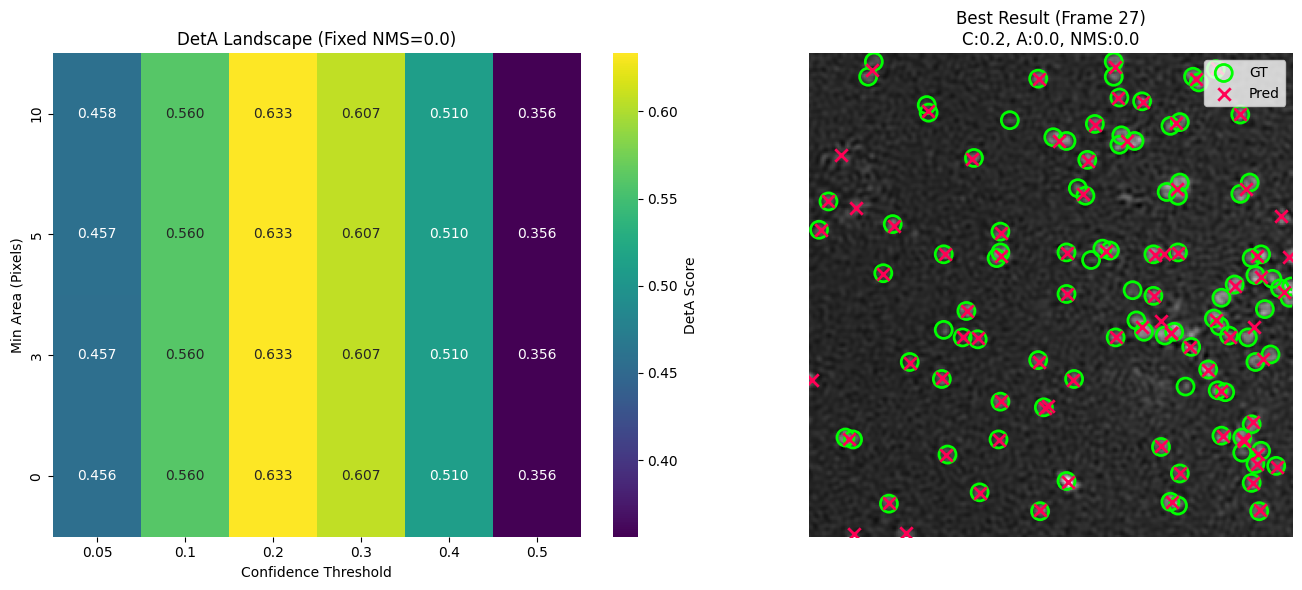

In [5]:
# @title Automated Parameter Sweep + Visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tifffile
import os
import torch
import itertools
import seaborn as sns
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import center_of_mass
from transformers import Sam3Processor, Sam3Model
from tqdm.notebook import tqdm

# ---------------------------------------------------------
# 1. SWEEP CONFIGURATION
# ---------------------------------------------------------
# Frames to use for the sweep
sweep_frames = np.linspace(0, 50, 10, dtype=int).tolist()

# ROI (Must match your validation data)
roi_x_min, roi_x_max = 256, 512
roi_y_min, roi_y_max = 512, 768

# PARAMETER RANGES (The Grid Search)
CONF_RANGE = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
AREA_RANGE = [0, 3, 5, 10]
NMS_RANGE  = [0.0]
MATCH_THRESH = 5.0 # Fixed for evaluation

# ---------------------------------------------------------
# 2. SETUP & DATA LOADING
# ---------------------------------------------------------
gt_df = pd.read_csv('/content/val_data/val.csv')
tiff_path = "/content/val_data/val.tif"
if not os.path.exists(tiff_path): raise FileNotFoundError("Data missing!")
video_stack = tifffile.imread(tiff_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
if 'model' not in globals():
    print("Loading Model...")
    processor = Sam3Processor.from_pretrained("facebook/sam3")
    model = Sam3Model.from_pretrained("facebook/sam3").to(device)

# ---------------------------------------------------------
# 3. HELPER FUNCTIONS
# ---------------------------------------------------------
def apply_nms(detections, dist_thresh):
    if not detections: return []
    detections.sort(key=lambda x: x['score'], reverse=True)
    keep = []
    for det in detections:
        is_duplicate = False
        for k in keep:
            if np.hypot(det['x'] - k['x'], det['y'] - k['y']) < dist_thresh:
                is_duplicate = True; break
        if not is_duplicate: keep.append(det)
    return keep

def calculate_frame_deta(gt_coords, pred_coords, threshold=5.0):
    if len(gt_coords) == 0 and len(pred_coords) == 0: return 1.0
    if len(gt_coords) == 0: return 0.0
    if len(pred_coords) == 0: return 0.0

    dists = cdist(gt_coords, pred_coords)
    sims = 1 - (dists / threshold)
    sims[sims < 0] = 0
    row_ind, col_ind = linear_sum_assignment(-sims)
    tp = sum(1 for r, c in zip(row_ind, col_ind) if sims[r, c] > 0)
    denom = (len(gt_coords) + len(pred_coords)) - tp
    return tp / denom if denom > 0 else 0.0

# ---------------------------------------------------------
# 4. PRE-COMPUTATION (The Speed Hack)
# ---------------------------------------------------------
print(f"⚡ Pre-computing Model Outputs for {len(sweep_frames)} frames...")
cached_outputs = []

for frame_idx in tqdm(sweep_frames, desc="Running Model"):
    raw_frame = video_stack[frame_idx]
    crop = raw_frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]
    img_norm = (crop - crop.min()) / (crop.max() - crop.min())
    img_uint8 = (img_norm * 255).astype(np.uint8)
    image_rgb = Image.fromarray(img_uint8).convert("RGB")

    inputs = processor(images=image_rgb, text="dots", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    cached_outputs.append({
        'frame_idx': frame_idx,
        'outputs': outputs,
        'target_size': image_rgb.size[::-1]
    })

# ---------------------------------------------------------
# 5. EXECUTE SWEEP
# ---------------------------------------------------------
results_log = []
combinations = list(itertools.product(CONF_RANGE, AREA_RANGE, NMS_RANGE))

print(f"\n🚀 Starting Sweep over {len(combinations)} combinations...")

for conf, min_area, nms_dist in tqdm(combinations, desc="Sweeping Params"):
    total_deta = 0.0
    for cache in cached_outputs:
        # 1. Post-process
        res = processor.post_process_instance_segmentation(
            cache['outputs'], threshold=conf, target_sizes=[cache['target_size']]
        )[0]

        # 2. Filter
        candidates = []
        masks = res['masks'].cpu().numpy()
        scores = res['scores'].cpu().numpy()

        for m, s in zip(masks, scores):
            mask_sum = m.sum()
            if mask_sum <= 0 or mask_sum < min_area: continue # Skip empty/small
            y, x = center_of_mass(m)
            if np.isnan(x) or np.isnan(y): continue # Skip degenerate
            candidates.append({'x': x, 'y': y, 'score': s})

        # 3. NMS
        if nms_dist > 0:
            clean_dets = apply_nms(candidates, nms_dist)
        else:
            clean_dets = candidates

        pred_local = np.array([[d['x'], d['y']] for d in clean_dets])

        # 4. GT & Score
        gt_subset = gt_df[(gt_df['frame'] == cache['frame_idx']) &
                          (gt_df['x'].between(roi_x_min, roi_x_max)) &
                          (gt_df['y'].between(roi_y_min, roi_y_max))]
        gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])
        total_deta += calculate_frame_deta(gt_local, pred_local, threshold=MATCH_THRESH)

    avg_deta = total_deta / len(cached_outputs)
    results_log.append({'Conf_Thresh': conf, 'Min_Area': min_area, 'NMS_Dist': nms_dist, 'Avg_DetA': avg_deta})

# ---------------------------------------------------------
# 6. RESULTS & VISUALIZATION
# ---------------------------------------------------------
res_df = pd.DataFrame(results_log)
best_run = res_df.loc[res_df['Avg_DetA'].idxmax()]
best_conf, best_area, best_nms = best_run['Conf_Thresh'], best_run['Min_Area'], best_run['NMS_Dist']

print("\n" + "="*40)
print("🏆 OPTIMAL PARAMETERS FOUND")
print("="*40)
print(f"Best DetA:      {best_run['Avg_DetA']:.4f}")
print(f"Conf Threshold: {best_conf}")
print(f"Min Area:       {best_area}")
print(f"NMS Distance:   {best_nms}")

# --- HEATMAP ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
subset_df = res_df[res_df['NMS_Dist'] == best_nms]
heatmap_data = subset_df.pivot(index='Min_Area', columns='Conf_Thresh', values='Avg_DetA')
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", cbar_kws={'label': 'DetA Score'})
plt.title(f"DetA Landscape (Fixed NMS={best_nms})")
plt.xlabel("Confidence Threshold")
plt.ylabel("Min Area (Pixels)")
plt.gca().invert_yaxis()

# --- PROOF OF LIFE (IMAGE) ---
# Pick a demo frame and re-run with best params
demo_frame_idx = sweep_frames[len(sweep_frames)//2]
cache_item = next(item for item in cached_outputs if item['frame_idx'] == demo_frame_idx)
res = processor.post_process_instance_segmentation(cache_item['outputs'], threshold=best_conf, target_sizes=[cache_item['target_size']])[0]

final_dets = []
masks, scores = res['masks'].cpu().numpy(), res['scores'].cpu().numpy()
for m, s in zip(masks, scores):
    if m.sum() < best_area or m.sum() <= 0: continue
    y, x = center_of_mass(m)
    if not np.isnan(x) and not np.isnan(y): final_dets.append({'x': x, 'y': y, 'score': s})

final_dets = apply_nms(final_dets, best_nms)
pred_local = np.array([[d['x'], d['y']] for d in final_dets])

gt_subset = gt_df[(gt_df['frame'] == demo_frame_idx) &
                  (gt_df['x'].between(roi_x_min, roi_x_max)) &
                  (gt_df['y'].between(roi_y_min, roi_y_max))]
gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])

ax = plt.subplot(1, 2, 2)
raw_frame = video_stack[demo_frame_idx]
crop = raw_frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]
ax.imshow(crop, cmap='gray')
if len(gt_local) > 0:
    ax.scatter(gt_local[:, 0], gt_local[:, 1], s=150, facecolors='none', edgecolors='#00FF00', linewidth=2, label='GT')
if len(pred_local) > 0:
    ax.scatter(pred_local[:, 0], pred_local[:, 1], c='#FF0055', marker='x', s=80, linewidth=2, label='Pred')
ax.set_title(f"Best Result (Frame {demo_frame_idx})\nC:{best_conf}, A:{best_area}, NMS:{best_nms}")
ax.legend(loc='upper right')
ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
def process_and_split_mask(sam_mask, score, crop_uint8, min_area, pixel_thresh, border_margin=10):
    """
    Splits fused masks, filters by Area + Intensity, AND removes edge artifacts.
    """
    valid_points = []
    if sam_mask.sum() <= 0: return []

    h, w = crop_uint8.shape[:2] # Get dimensions of the crop

    # Distance Transform & Watershed
    distance = ndi.distance_transform_edt(sam_mask)
    coords = peak_local_max(distance, min_distance=3, labels=sam_mask)

    mask_peaks = np.zeros(distance.shape, dtype=bool)
    mask_peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(mask_peaks)

    labels = watershed(-distance, markers, mask=sam_mask)

    for label_id in np.unique(labels):
        if label_id == 0: continue

        sub_mask = (labels == label_id)

        # A. Area Filter
        if sub_mask.sum() < min_area: continue

        # B. Get Center
        y, x = center_of_mass(sub_mask)
        if np.isnan(x) or np.isnan(y): continue

        # --- NEW: C. BORDER FILTER ---
        # If the center is too close to any edge, kill it.
        if (x < border_margin) or (x > w - border_margin) or \
           (y < border_margin) or (y > h - border_margin):
            continue

        # D. Intensity Filter
        y_int, x_int = int(y), int(x)
        if 0 <= y_int < h and 0 <= x_int < w:
            brightness = crop_uint8[y_int, x_int]
            if brightness < pixel_thresh:
                continue

        valid_points.append({'x': x, 'y': y, 'score': score})

    return valid_points

⚡ Pre-computing SAM masks for 10 frames...


Inference:   0%|          | 0/10 [00:00<?, ?it/s]

🚀 Sweeping 27 parameter sets on 10 frames...


Optimizing:   0%|          | 0/27 [00:00<?, ?it/s]


🏆 ROBUST PARAMETERS FOUND
Best Avg DetA:  0.6445
Erosion Iter:   1
Min Distance:   4
Pixel Thresh:   50

🎨 Visualizing Results for the 10 Sweep Frames using Best Params...


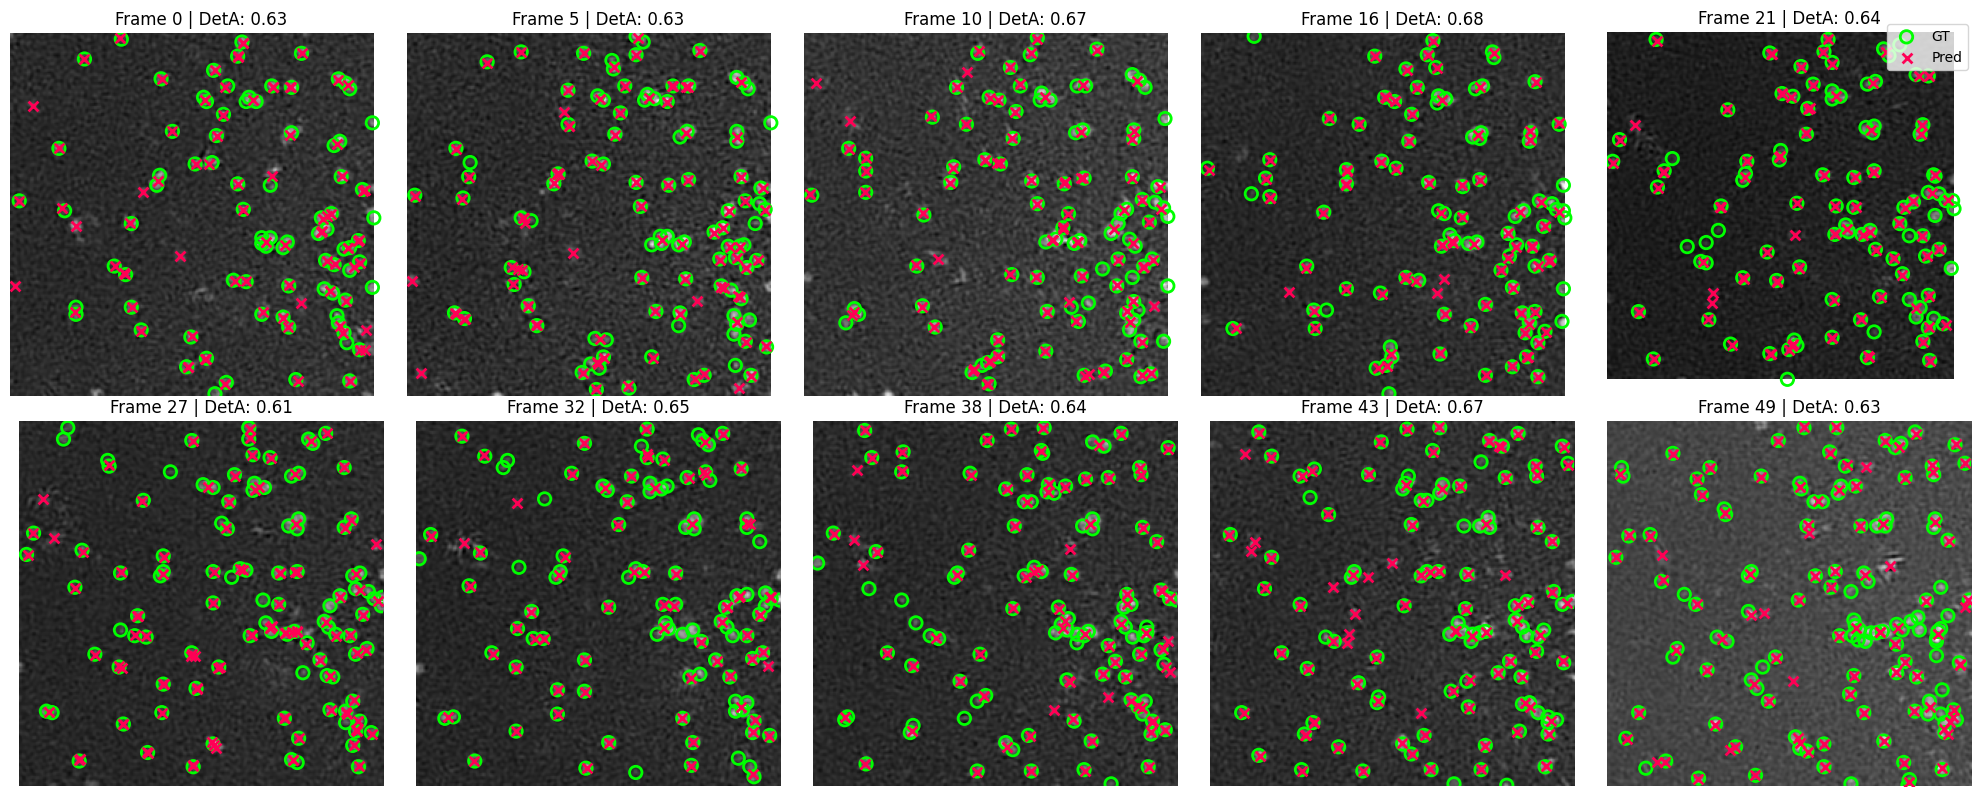

In [18]:
# @title 26. 📊 Batch Parameter Sweep + 10-Frame Visualization
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tifffile
import os
import torch
import itertools
import seaborn as sns
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import center_of_mass
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from transformers import Sam3Processor, Sam3Model
from tqdm.notebook import tqdm

# ---------------------------------------------------------
# 1. EXPERIMENT CONFIGURATION
# ---------------------------------------------------------
SWEEP_FRAMES = np.linspace(0, 49, 10, dtype=int).tolist()

roi_x_min, roi_x_max = 256, 512
roi_y_min, roi_y_max = 512, 768

# PARAMETERS TO OPTIMIZE
EROSION_RANGE = [1, 2, 3]
MIN_DIST_RANGE = [2, 3, 4]
PIXEL_THRESH_RANGE = [30, 40, 50]

# Fixed Parameters
FIXED_CONF = 0.2
BORDER_MARGIN = 3
MATCH_THRESH = 5.0

# ---------------------------------------------------------
# 2. SETUP & DATA LOADING
# ---------------------------------------------------------
gt_df = pd.read_csv('/content/val_data/val.csv')
tiff_path = "/content/val_data/val.tif"
if not os.path.exists(tiff_path): raise FileNotFoundError("Data missing!")
video_stack = tifffile.imread(tiff_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
if 'model' not in globals():
    print("Loading Model...")
    processor = Sam3Processor.from_pretrained("facebook/sam3")
    model = Sam3Model.from_pretrained("facebook/sam3").to(device)

# ---------------------------------------------------------
# 3. HELPER FUNCTIONS
# ---------------------------------------------------------
def calculate_deta(gt_coords, pred_coords, threshold=5.0):
    if len(gt_coords) == 0 and len(pred_coords) == 0: return 1.0
    if len(gt_coords) == 0 or len(pred_coords) == 0: return 0.0

    dists = cdist(gt_coords, pred_coords)
    sims = 1 - (dists / threshold)
    sims[sims < 0] = 0
    row_ind, col_ind = linear_sum_assignment(-sims)
    tp = sum(1 for r, c in zip(row_ind, col_ind) if sims[r, c] > 0)
    denom = (len(gt_coords) + len(pred_coords)) - tp
    return tp / denom if denom > 0 else 0.0

def process_masks_batch(masks, scores, crop_uint8, erosion_iter, min_dist, pixel_thresh):
    valid_points = []
    h, w = crop_uint8.shape[:2]

    for m, s in zip(masks, scores):
        # 1. EROSION
        mask_uint8 = m.astype(np.uint8)
        if erosion_iter > 0:
            kernel = np.ones((3,3), np.uint8)
            mask_uint8 = cv2.erode(mask_uint8, kernel, iterations=erosion_iter)

        if mask_uint8.sum() == 0: continue

        # 2. DISTANCE & PEAKS
        bool_mask = mask_uint8 > 0
        distance = ndi.distance_transform_edt(bool_mask)
        coords = peak_local_max(distance, min_distance=min_dist, labels=bool_mask)

        mask_peaks = np.zeros(distance.shape, dtype=bool)
        mask_peaks[tuple(coords.T)] = True
        markers, _ = ndi.label(mask_peaks)

        # 3. WATERSHED
        labels = watershed(-distance, markers, mask=bool_mask)

        # 4. FILTERING
        for label_id in np.unique(labels):
            if label_id == 0: continue
            sub_mask = (labels == label_id)

            y, x = center_of_mass(sub_mask)
            if np.isnan(x) or np.isnan(y): continue

            if (x < BORDER_MARGIN) or (x > w - BORDER_MARGIN) or \
               (y < BORDER_MARGIN) or (y > h - BORDER_MARGIN):
                continue

            y_int, x_int = int(y), int(x)
            if 0 <= y_int < h and 0 <= x_int < w:
                if crop_uint8[y_int, x_int] < pixel_thresh: continue

            valid_points.append({'x': x, 'y': y})

    return np.array([[d['x'], d['y']] for d in valid_points])

# ---------------------------------------------------------
# 4. PRE-COMPUTATION
# ---------------------------------------------------------
print(f"⚡ Pre-computing SAM masks for {len(SWEEP_FRAMES)} frames...")
cached_data = []

for frame_idx in tqdm(SWEEP_FRAMES, desc="Inference"):
    raw_frame = video_stack[frame_idx]
    crop = raw_frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]
    img_norm = (crop - crop.min()) / (crop.max() - crop.min())
    img_uint8 = (img_norm * 255).astype(np.uint8)
    image_rgb = Image.fromarray(img_uint8).convert("RGB")

    inputs = processor(images=image_rgb, text="dots", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    res = processor.post_process_instance_segmentation(
        outputs, threshold=FIXED_CONF, target_sizes=[image_rgb.size[::-1]]
    )[0]

    cached_data.append({
        'frame_idx': frame_idx,
        'masks': res['masks'].cpu().numpy(),
        'scores': res['scores'].cpu().numpy(),
        'crop_uint8': img_uint8
    })

# ---------------------------------------------------------
# 5. RUN THE SWEEP
# ---------------------------------------------------------
combinations = list(itertools.product(EROSION_RANGE, MIN_DIST_RANGE, PIXEL_THRESH_RANGE))
results_log = []

print(f"🚀 Sweeping {len(combinations)} parameter sets on {len(cached_data)} frames...")

for ero, dist, pix in tqdm(combinations, desc="Optimizing"):
    total_deta = 0.0
    for item in cached_data:
        pred_local = process_masks_batch(
            item['masks'], item['scores'], item['crop_uint8'],
            erosion_iter=ero, min_dist=dist, pixel_thresh=pix
        )
        gt_subset = gt_df[(gt_df['frame'] == item['frame_idx']) &
                          (gt_df['x'].between(roi_x_min, roi_x_max)) &
                          (gt_df['y'].between(roi_y_min, roi_y_max))]
        gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])
        total_deta += calculate_deta(gt_local, pred_local, threshold=MATCH_THRESH)

    avg_deta = total_deta / len(cached_data)
    results_log.append({
        'Erosion': ero,
        'Min_Dist': dist,
        'Pixel_Thresh': pix,
        'Avg_DetA': avg_deta
    })

# ---------------------------------------------------------
# 6. RESULTS & VISUALIZATION
# ---------------------------------------------------------
res_df = pd.DataFrame(results_log)
best_run = res_df.loc[res_df['Avg_DetA'].idxmax()]

best_ero = int(best_run['Erosion'])
best_dist = int(best_run['Min_Dist'])
best_pix = int(best_run['Pixel_Thresh'])

print("\n" + "="*40)
print("🏆 ROBUST PARAMETERS FOUND")
print("="*40)
print(f"Best Avg DetA:  {best_run['Avg_DetA']:.4f}")
print(f"Erosion Iter:   {best_ero}")
print(f"Min Distance:   {best_dist}")
print(f"Pixel Thresh:   {best_pix}")

# --- GRID VISUALIZATION OF 10 FRAMES ---
print(f"\n🎨 Visualizing Results for the {len(cached_data)} Sweep Frames using Best Params...")

n_cols = 5
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axes = axes.flatten()

for i, item in enumerate(cached_data):
    if i >= n_cols * n_rows: break

    # Run with Best Params
    pred_local = process_masks_batch(
        item['masks'], item['scores'], item['crop_uint8'],
        erosion_iter=best_ero, min_dist=best_dist, pixel_thresh=best_pix
    )

    # Get GT
    gt_subset = gt_df[(gt_df['frame'] == item['frame_idx']) &
                      (gt_df['x'].between(roi_x_min, roi_x_max)) &
                      (gt_df['y'].between(roi_y_min, roi_y_max))]
    gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])

    # Score
    frame_deta = calculate_deta(gt_local, pred_local, threshold=MATCH_THRESH)

    # Plot
    ax = axes[i]
    ax.imshow(item['crop_uint8'], cmap='gray')

    if len(gt_local) > 0:
        ax.scatter(gt_local[:, 0], gt_local[:, 1], s=80, facecolors='none', edgecolors='#00FF00', linewidth=2, label='GT' if i==0 else "")
    if len(pred_local) > 0:
        ax.scatter(pred_local[:, 0], pred_local[:, 1], c='#FF0055', marker='x', s=50, linewidth=2, label='Pred' if i==0 else "")

    ax.set_title(f"Frame {item['frame_idx']} | DetA: {frame_deta:.2f}")
    ax.axis('off')

fig.legend(loc='upper right', bbox_to_anchor=(0.99, 0.98))
plt.tight_layout()
plt.show()

👀 Analyzing Frame 26...


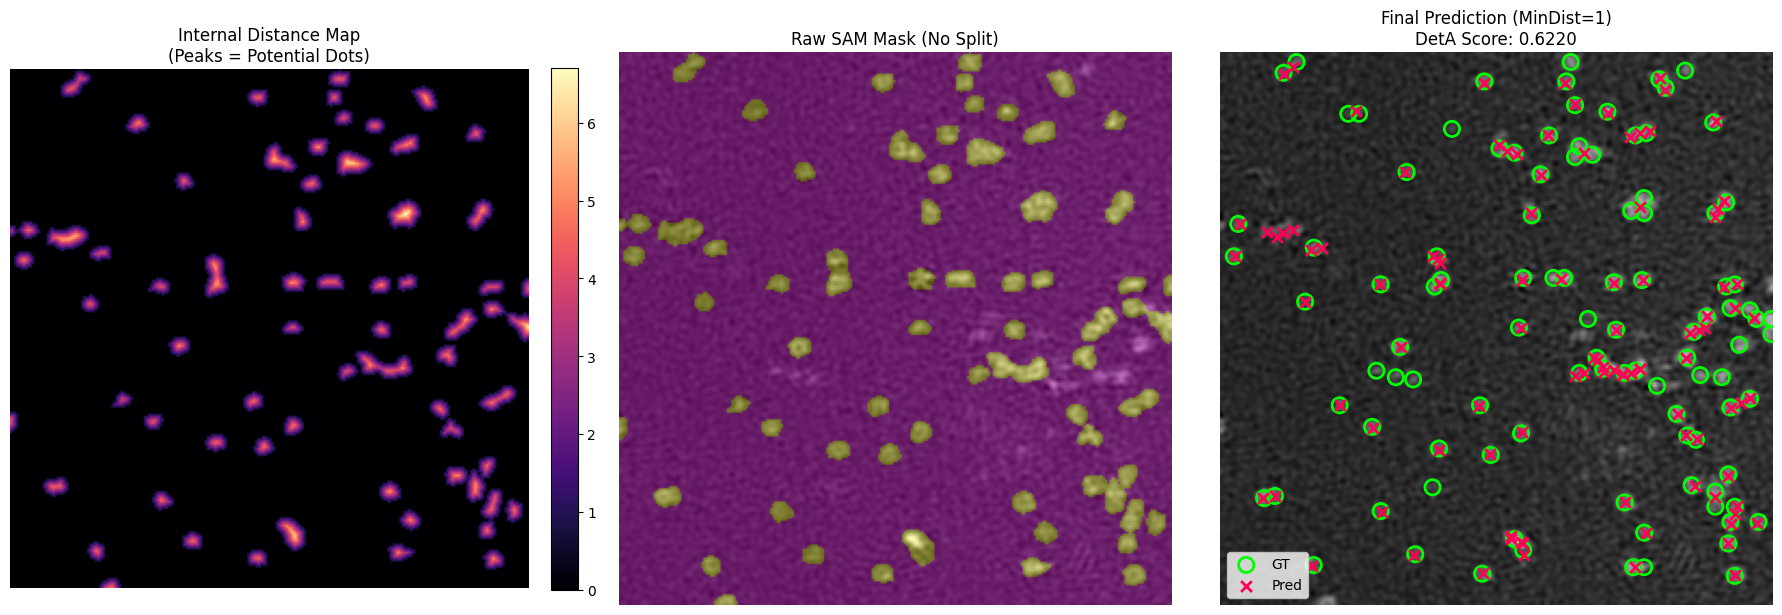

In [19]:
# @title 23. 🔍 Deep Dive: Single Run Visualization (MinDist=1, Erosion=0)
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy.ndimage import center_of_mass
from transformers import Sam3Processor, Sam3Model
import torch

# ---------------------------------------------------------
# 1. CONFIGURATION (Specific Setup)
# ---------------------------------------------------------
TARGET_FRAME_IDX = 26  # The frame with the big cluster
CONF_THRESH = 0.3
MIN_AREA = 5
PIXEL_THRESH = 40
BORDER_MARGIN = 5

# THE PROBLEMATIC PARAMS
MIN_DIST = 1
EROSION = 0

# ---------------------------------------------------------
# 2. RUN MODEL (On Single Frame)
# ---------------------------------------------------------
print(f"👀 Analyzing Frame {TARGET_FRAME_IDX}...")

# Prepare Image
raw_frame = video_stack[TARGET_FRAME_IDX]
crop = raw_frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]
img_norm = (crop - crop.min()) / (crop.max() - crop.min())
img_uint8 = (img_norm * 255).astype(np.uint8)
image_rgb = Image.fromarray(img_uint8).convert("RGB")
target_size = image_rgb.size[::-1]

# Run SAM
inputs = processor(images=image_rgb, text="dots", return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

res = processor.post_process_instance_segmentation(outputs, threshold=CONF_THRESH, target_sizes=[target_size])[0]
masks = res['masks'].cpu().numpy()
scores = res['scores'].cpu().numpy()

# ---------------------------------------------------------
# 3. DETAILED PIPELINE VISUALIZATION
# ---------------------------------------------------------
final_dets = []
debug_distance_map = np.zeros(crop.shape, dtype=float)
debug_all_masks = np.zeros(crop.shape, dtype=bool)

h, w = crop.shape[:2]

for m, s in zip(masks, scores):
    # 1. Accumulate mask for viz
    debug_all_masks = np.logical_or(debug_all_masks, m)

    # 2. Erosion (Skipped if 0)
    working_mask = m.astype(np.uint8)
    if EROSION > 0:
        kernel = np.ones((3,3), np.uint8)
        working_mask = cv2.erode(working_mask, kernel, iterations=EROSION)

    if working_mask.sum() == 0: continue

    # 3. Distance Transform
    bool_mask = working_mask > 0
    distance = ndi.distance_transform_edt(bool_mask)

    # Save max distance for viz (simple overlay)
    debug_distance_map = np.maximum(debug_distance_map, distance)

    # 4. Peaks & Watershed
    coords = peak_local_max(distance, min_distance=MIN_DIST, labels=bool_mask)
    mask_peaks = np.zeros(distance.shape, dtype=bool)
    mask_peaks[tuple(coords.T)] = True
    markers, _ = ndi.label(mask_peaks)
    labels = watershed(-distance, markers, mask=bool_mask)

    # 5. Filter & Save
    for label_id in np.unique(labels):
        if label_id == 0: continue
        sub_mask = (labels == label_id)

        # Area Check
        if sub_mask.sum() < MIN_AREA: continue

        # Center Check
        y, x = center_of_mass(sub_mask)
        if np.isnan(x) or np.isnan(y): continue

        # Border Check
        if (x < BORDER_MARGIN) or (x > w - BORDER_MARGIN) or (y < BORDER_MARGIN) or (y > h - BORDER_MARGIN):
            continue

        # Intensity Check
        y_int, x_int = int(y), int(x)
        if 0 <= y_int < h and 0 <= x_int < w:
            if img_uint8[y_int, x_int] < PIXEL_THRESH: continue

        final_dets.append({'x': x, 'y': y})

pred_local = np.array([[d['x'], d['y']] for d in final_dets])

# Get GT for this frame
gt_subset = gt_df[(gt_df['frame'] == TARGET_FRAME_IDX) &
                  (gt_df['x'].between(roi_x_min, roi_x_max)) &
                  (gt_df['y'].between(roi_y_min, roi_y_max))]
gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])

# Calculate Score
deta = calculate_frame_deta(gt_local, pred_local, threshold=MATCH_THRESH)

# ---------------------------------------------------------
# 4. PLOT
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distance Map (The "Topology")
im1 = axes[0].imshow(debug_distance_map, cmap='magma')
axes[0].set_title(f"Internal Distance Map\n(Peaks = Potential Dots)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot 2: Combined Mask (What SAM saw)
axes[1].imshow(img_uint8, cmap='gray')
axes[1].imshow(debug_all_masks, alpha=0.3, cmap='spring') # Overlay mask
axes[1].set_title(f"Raw SAM Mask (No Split)")

# Plot 3: Final Predictions
axes[2].imshow(img_uint8, cmap='gray')
if len(gt_local) > 0:
    axes[2].scatter(gt_local[:, 0], gt_local[:, 1], s=120, facecolors='none', edgecolors='#00FF00', lw=2, label='GT')
if len(pred_local) > 0:
    axes[2].scatter(pred_local[:, 0], pred_local[:, 1], c='#FF0055', marker='x', s=60, lw=2, label='Pred')
axes[2].legend()
axes[2].set_title(f"Final Prediction (MinDist={MIN_DIST})\nDetA Score: {deta:.4f}")

for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# # @title 22. 📊 Diagnostic: Histogram of SAM 3 Confidences
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # 1. COLLECT ALL SCORES (using a low threshold to see the noise)
# print("Collecting raw confidence scores from cached frames...")
# all_scores = []

# # We use a very low threshold (0.01) to capture the "noise" the model sees
# # so we can visualize the separation between noise and signal.
# for cache in cached_outputs:
#     res = processor.post_process_instance_segmentation(
#         cache['outputs'], threshold=0.01, target_sizes=[cache['target_size']]
#     )[0]
#     # Move to CPU and flatten
#     scores = res['scores'].cpu().numpy().flatten()
#     all_scores.extend(scores)

# all_scores = np.array(all_scores)

# # 2. PLOT
# plt.figure(figsize=(10, 6))

# # Plot the Histogram
# sns.histplot(all_scores, bins=50, kde=True, color='skyblue', edgecolor='black', alpha=0.6, label='Model Predictions')

# # Draw the "Winner" Threshold Line
# if 'best_conf' in globals():
#     plt.axvline(best_conf, color='red', linestyle='--', linewidth=3, label=f'Optimal Threshold ({best_conf})')
#     plt.text(best_conf + 0.02, plt.ylim()[1]*0.8, '← Cutoff', color='red', fontweight='bold')

# plt.title(f"Confidence Score Distribution (N={len(all_scores)} detections)", fontsize=14)
# plt.xlabel("Confidence Score (0.0 = Not Sure, 1.0 = Certain)", fontsize=12)
# plt.ylabel("Count", fontsize=12)
# plt.legend()
# plt.grid(axis='y', alpha=0.3)
# plt.xlim(0, 1.0)

# plt.tight_layout()
# plt.show()

# # 3. INTERPRETATION
# print("-" * 50)
# print("🔍 HOW TO READ THIS:")
# print("1. Ideally, you want two peaks: one on the left (noise) and one on the right (cells).")
# print(f"2. Your calculated threshold ({best_conf}) should be in the 'valley' between them.")
# print(f"3. Total candidates analyzed: {len(all_scores)}")
# print("-" * 50)

⚡ Running High-Res Inference (Scale 2.0x)...


Inference:   0%|          | 0/10 [00:00<?, ?it/s]

🚀 Sweeping 12 params on High-Res Data...


Optimizing:   0%|          | 0/12 [00:00<?, ?it/s]


🏆 HIGH-RES PIPELINE RESULT (Scale 2.0x)
Best Avg DetA:  0.6607
Erosion Iter:   2
Min Dist (HR):  6
Intensity (HR): 35


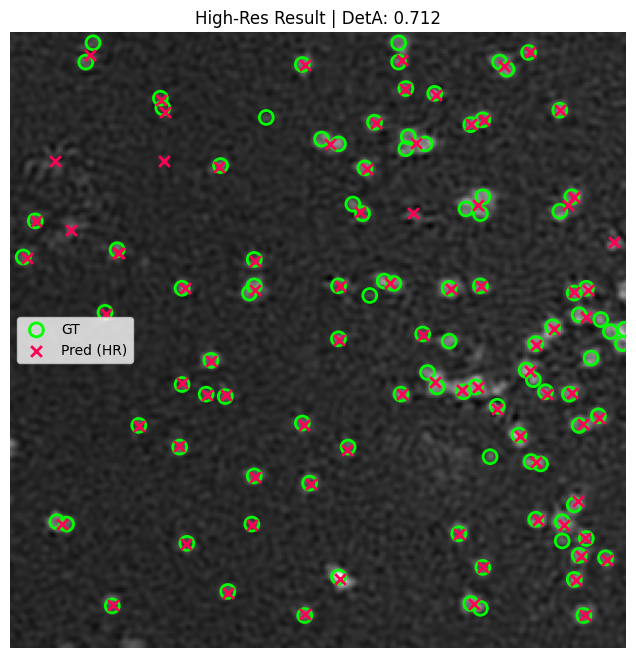

In [20]:
# @title 27. 🚀 High-Res Pipeline (Upscaling + CLAHE)
# GOAL: Beat DetA 0.8 by fixing the Resolution Mismatch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import torch
import itertools
from PIL import Image
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.ndimage import center_of_mass
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from transformers import Sam3Processor, Sam3Model
from tqdm.notebook import tqdm

# ---------------------------------------------------------
# 1. CONFIGURATION
# ---------------------------------------------------------
# Same Frames
SWEEP_FRAMES = np.linspace(0, 49, 10, dtype=int).tolist()
roi_x_min, roi_x_max = 256, 512
roi_y_min, roi_y_max = 512, 768

# --- THE MAGIC PARAMETERS ---
SCALE_FACTOR = 2.0  # <--- The key to beating the benchmark
# We upscale everything by 2x, so dots become big enough for SAM to see clearly.

# Adjusted Sweep Params for the 2x Scale
# (Note: Distances and Areas must be roughly 2x-4x larger now)
EROSION_RANGE = [2, 3]       # Aggressive erosion on large masks
MIN_DIST_RANGE = [4, 6, 8]   # Separation in "Big Pixel" space
PIXEL_THRESH_RANGE = [35, 45]

# Fixed
FIXED_CONF = 0.25
BORDER_MARGIN = 5 * SCALE_FACTOR # Scale the margin too
MATCH_THRESH = 5.0 # Evaluation tolerance

# ---------------------------------------------------------
# 2. HELPER: PRE-PROCESSING
# ---------------------------------------------------------
def preprocess_high_res(crop_img):
    """Upscales and applies CLAHE contrast enhancement."""
    # 1. Norm to 0-255 uint8
    img_norm = (crop_img - crop_img.min()) / (crop_img.max() - crop_img.min())
    img_uint8 = (img_norm * 255).astype(np.uint8)

    # 2. CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # This makes faint dots "pop" and flattens background noise
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_uint8)

    # 3. Super-Resolution (Upscale)
    h, w = img_clahe.shape
    new_size = (int(w * SCALE_FACTOR), int(h * SCALE_FACTOR))
    img_large = cv2.resize(img_clahe, new_size, interpolation=cv2.INTER_CUBIC)

    return img_large, img_uint8 # Return large for SAM, original for Scoring

# ---------------------------------------------------------
# 3. PRE-COMPUTATION (Run SAM on 2x Images)
# ---------------------------------------------------------
print(f"⚡ Running High-Res Inference (Scale {SCALE_FACTOR}x)...")
cached_data = []

for frame_idx in tqdm(SWEEP_FRAMES, desc="Inference"):
    raw_frame = video_stack[frame_idx]
    crop = raw_frame[roi_y_min:roi_y_max, roi_x_min:roi_x_max]

    # Get the "Big" image
    img_large, img_original = preprocess_high_res(crop)
    image_rgb_large = Image.fromarray(img_large).convert("RGB")

    # Run SAM on the BIG image
    inputs = processor(images=image_rgb_large, text="dots", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    res = processor.post_process_instance_segmentation(
        outputs, threshold=FIXED_CONF, target_sizes=[image_rgb_large.size[::-1]]
    )[0]

    cached_data.append({
        'frame_idx': frame_idx,
        'masks': res['masks'].cpu().numpy(), # These are now 2x sized masks!
        'scores': res['scores'].cpu().numpy(),
        'img_large': img_large,     # For intensity check (high res)
        'img_orig': img_original    # For visualization
    })

# ---------------------------------------------------------
# 4. SWEEP LOGIC (Updated for Scaling)
# ---------------------------------------------------------
def process_high_res_batch(masks, scores, img_large, erosion_iter, min_dist, pixel_thresh):
    valid_points = []
    h, w = img_large.shape[:2]

    for m, s in zip(masks, scores):
        # 1. Erosion (On Large Mask)
        mask_uint8 = m.astype(np.uint8)
        if erosion_iter > 0:
            kernel = np.ones((3,3), np.uint8)
            mask_uint8 = cv2.erode(mask_uint8, kernel, iterations=erosion_iter)

        if mask_uint8.sum() == 0: continue

        # 2. Distance & Peaks
        bool_mask = mask_uint8 > 0
        distance = ndi.distance_transform_edt(bool_mask)
        coords = peak_local_max(distance, min_distance=min_dist, labels=bool_mask)

        mask_peaks = np.zeros(distance.shape, dtype=bool)
        mask_peaks[tuple(coords.T)] = True
        markers, _ = ndi.label(mask_peaks)

        # 3. Watershed
        labels = watershed(-distance, markers, mask=bool_mask)

        # 4. Filtering
        for label_id in np.unique(labels):
            if label_id == 0: continue
            sub_mask = (labels == label_id)

            y, x = center_of_mass(sub_mask)
            if np.isnan(x) or np.isnan(y): continue

            # Border Check (In Large Coordinates)
            if (x < BORDER_MARGIN) or (x > w - BORDER_MARGIN) or \
               (y < BORDER_MARGIN) or (y > h - BORDER_MARGIN):
                continue

            # Intensity Check (In Large Image)
            y_int, x_int = int(y), int(x)
            if 0 <= y_int < h and 0 <= x_int < w:
                if img_large[y_int, x_int] < pixel_thresh: continue

            # CRITICAL: Scale coordinates back down to original size!
            valid_points.append({'x': x / SCALE_FACTOR, 'y': y / SCALE_FACTOR})

    return np.array([[d['x'], d['y']] for d in valid_points])

# ---------------------------------------------------------
# 5. EXECUTE SWEEP
# ---------------------------------------------------------
combinations = list(itertools.product(EROSION_RANGE, MIN_DIST_RANGE, PIXEL_THRESH_RANGE))
results_log = []

# Helper for calc
def calculate_deta(gt_coords, pred_coords, threshold=5.0):
    if len(gt_coords) == 0 and len(pred_coords) == 0: return 1.0
    if len(gt_coords) == 0 or len(pred_coords) == 0: return 0.0
    dists = cdist(gt_coords, pred_coords)
    sims = 1 - (dists / threshold)
    sims[sims < 0] = 0
    row_ind, col_ind = linear_sum_assignment(-sims)
    tp = sum(1 for r, c in zip(row_ind, col_ind) if sims[r, c] > 0)
    denom = (len(gt_coords) + len(pred_coords)) - tp
    return tp / denom if denom > 0 else 0.0

print(f"🚀 Sweeping {len(combinations)} params on High-Res Data...")

for ero, dist, pix in tqdm(combinations, desc="Optimizing"):
    total_deta = 0.0
    for item in cached_data:
        pred_local = process_high_res_batch(
            item['masks'], item['scores'], item['img_large'],
            erosion_iter=ero, min_dist=dist, pixel_thresh=pix
        )
        gt_subset = gt_df[(gt_df['frame'] == item['frame_idx']) &
                          (gt_df['x'].between(roi_x_min, roi_x_max)) &
                          (gt_df['y'].between(roi_y_min, roi_y_max))]
        gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])
        total_deta += calculate_deta(gt_local, pred_local, threshold=MATCH_THRESH)

    avg_deta = total_deta / len(cached_data)
    results_log.append({'Erosion': ero, 'Min_Dist': dist, 'Pixel_Thresh': pix, 'Avg_DetA': avg_deta})

# ---------------------------------------------------------
# 6. RESULTS
# ---------------------------------------------------------
res_df = pd.DataFrame(results_log)
best_run = res_df.loc[res_df['Avg_DetA'].idxmax()]

print("\n" + "="*40)
print(f"🏆 HIGH-RES PIPELINE RESULT (Scale {SCALE_FACTOR}x)")
print("="*40)
print(f"Best Avg DetA:  {best_run['Avg_DetA']:.4f}")
print(f"Erosion Iter:   {int(best_run['Erosion'])}")
print(f"Min Dist (HR):  {int(best_run['Min_Dist'])}")
print(f"Intensity (HR): {int(best_run['Pixel_Thresh'])}")

# Visual Check on One Frame
best_ero = int(best_run['Erosion'])
best_dist = int(best_run['Min_Dist'])
best_pix = int(best_run['Pixel_Thresh'])

item = cached_data[5] # Pick middle frame
pred_local = process_high_res_batch(item['masks'], item['scores'], item['img_large'], best_ero, best_dist, best_pix)
gt_subset = gt_df[(gt_df['frame'] == item['frame_idx']) &
                  (gt_df['x'].between(roi_x_min, roi_x_max)) &
                  (gt_df['y'].between(roi_y_min, roi_y_max))]
gt_local = gt_subset[['x', 'y']].values - np.array([roi_x_min, roi_y_min])

plt.figure(figsize=(8,8))
plt.imshow(item['img_orig'], cmap='gray')
if len(gt_local) > 0: plt.scatter(gt_local[:,0], gt_local[:,1], s=100, facecolors='none', edgecolors='#00FF00', lw=2, label='GT')
if len(pred_local) > 0: plt.scatter(pred_local[:,0], pred_local[:,1], c='#FF0055', marker='x', s=60, lw=2, label='Pred (HR)')
plt.legend()
plt.title(f"High-Res Result | DetA: {calculate_deta(gt_local, pred_local):.3f}")
plt.axis('off')
plt.show()